<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-data-from-a-database" data-toc-modified-id="Loading-data-from-a-database-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading data from a database</a></span></li><li><span><a href="#Scatterplot-to-compare-true-and-predicted-values" data-toc-modified-id="Scatterplot-to-compare-true-and-predicted-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scatterplot to compare true and predicted values</a></span></li><li><span><a href="#Boxplot-to-compare-2-ranges" data-toc-modified-id="Boxplot-to-compare-2-ranges-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Boxplot to compare 2 ranges</a></span></li><li><span><a href="#False-positive-rate" data-toc-modified-id="False-positive-rate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>False positive rate</a></span></li><li><span><a href="#Gradient-descent" data-toc-modified-id="Gradient-descent-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Gradient descent</a></span></li><li><span><a href="#Make-interactions-for-linear-regression" data-toc-modified-id="Make-interactions-for-linear-regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make interactions for linear regression</a></span></li><li><span><a href="#Visualize-different-regilarization-coefficients" data-toc-modified-id="Visualize-different-regilarization-coefficients-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualize different regilarization coefficients</a></span></li><li><span><a href="#Get-coefficients-of-Linear-Regression" data-toc-modified-id="Get-coefficients-of-Linear-Regression-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Get coefficients of Linear Regression</a></span></li></ul></div>

# My code to reuse

In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## Loading data from a database

In [2]:
sql_query = """
select 
    p.*,
    mp.*
from 
    database.mech_properties mp,
    database.piece_info p
where 
    mp."ID MES" = p."ID MES" -- ID MES is used to join data
    and p."date_of_production" between to_date('01.12.2021 00:00:00', 'DD.MM.YYYY HH24:mi:ss')
                                       and to_date('31.12.2021 23:59:59', 'DD.MM.YYYY HH24:mi:ss')
"""         

In [3]:
%%time

dsn_tns = cx_Oracle.makedsn('xxxxxx.com', '1521',
                            service_name='yyyyyyyyyyyyy.com')
conn = cx_Oracle.connect(dsn=dsn_tns)
cursor = conn.cursor() 
df = pd.DataFrame(cursor.execute(sql_query_all).fetchall())

# Making column names
table_columns = [column[0] for column in cursor.description]
df.columns = table_columns

conn.close()

DatabaseError: ORA-12170: TNS:Connect timeout occurred

## Scatterplot to compare true and predicted values

In [4]:
def true_vs_predicted_plot(y_true, y_predicted, title, true_label, predicted_label):
    """
    Функция для построения графика сравнения расчитанного значения с фактическим.
    x=y_predicted,
    y=y_true
    """

    min_val = min([min(y_true), min(y_predicted)])
    max_val = max([max(y_true), max(y_predicted)])
    range_val = max_val - min_val
    r_2 = r2_score(y_true, y_predicted)

    plt.figure(figsize=(6, 6))
    plt.scatter(x=y_predicted,
                y=y_true)
    plt.plot([min_val, max_val], [min_val, max_val], linestyle=':')
    plt.xlabel(predicted_label)
    plt.ylabel(true_label)
    plt.title(title)
    plt.grid(linestyle=':')
    plt.text(x=min_val + range_val * 0.25,
             y=min_val + range_val * 0.75,
             s=f'$R^2$ ={round(r_2, 2)}')
    plt.show()

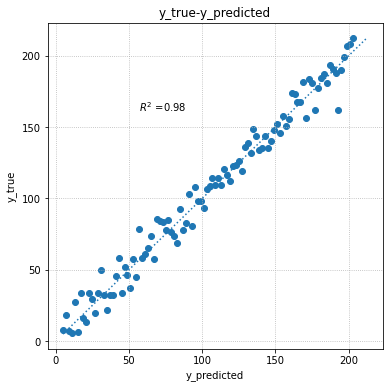

In [5]:
# example
x = np.arange(0, 100, 1)
noise = np.random.randn(100)*10
y_true = x*2 + 5 + noise
y_predicted = x*2 + 5

true_vs_predicted_plot(y_true=y_true, y_predicted=y_predicted,
                       title='y_true-y_predicted',
                       true_label='y_true',
                       predicted_label='y_predicted')

## Boxplot to compare 2 ranges

In [6]:
def boxplot_for_comparison(parameter_1, parameter_2, labels, title):
    """
    Функция для совместного изображения ящиков с усами
    для содержаний каждого химческого элемента
    - в выборке, использованной для построения модели "ТИХ 2.0";
    - в выборке слябров с трещинами, причиннами которых может быть склонность стали к ТИХ.
    
    * parameter_1 - список значений величины 1;
    * parameter_2 - список значений величины 2;
    * labels - список названий для каждого ящика ['parameter_1', 'parameter_2'];
    * title - Название графика.
    
    """

    plt.boxplot((parameter_1, parameter_2),
                labels=labels)
    plt.title(title)
    plt.show()
    

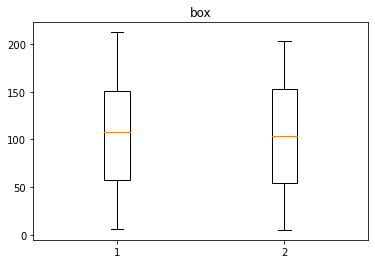

In [7]:
# Example
boxplot_for_comparison(parameter_1=y_true,
                       parameter_2=y_predicted,
                       labels=['1', '2'],
                       title='box')

## False positive rate 

In [ ]:
def false_positive_rate(y_true, y_pred):
    """
    Функция, которая расчитывает false posotive rate - долю ложноположтельных среди всех реально отрицательных:
    FPR = FP / N  или FPR = FP / (FP + TN)
    - tp (true positive) реально положительных прогнозов;
    - tn (true negative) реально отрицательных прогнозов;
    - fp (false positive) ложноположительных прогнозов;
    - fn (false negative) ложноотрицательных прогнозов;
    """
    tn, fp = 0, 0
    for true, pred in zip(y_true, y_pred):
        if (pred == 1) & (true != pred):
                fp += 1
        if (pred == 0) & (true == pred):
                tn += 1
    return fp / (fp + tn)

In [ ]:
def tp_tn_fp_fn(y_true, y_pred):
    """
    Функция, которая расчитывает количество 
    - tp (true positive) реально положительных прогнозов;
    - tn (true negative) реально отрицательных прогнозов;
    - fp (false positive) ложноположительных прогнозов;
    - fn (false negative) ложноотрицательных прогнозов;
    """
    tp, tn, fp, fn = 0, 0, 0, 0
    for true, pred in zip(y_true, y_pred):
        if pred == 1:
            if true == pred:
                tp += 1
            else:
                fp += 1
        if pred == 0:
            if true == pred:
                tn += 1
            else:
                fn += 1       
    return tp, tn, fp, fn
        

## Gradient descent

In [ ]:
def gradient_descent(X, y, coeffs, learning_rate=1e-06, tolerance=1e-04, n_iter=500,
                     verbose=False, return_mse_history=False):
    
    """
    * X - матрица значений признаков (n, k), где n - количество наблюдений, k - количство признаков
    * y - значения предсказываемой переменной, вектор длиной n
    * coeffs - первое приближение в коэффициентов линейной модели в виде вектора: (intercept, a1, ...ak)
    * learning_rate - шаг градиентного спуска
    * tolerance - допустимая ошибка
    * n_iter - количество итераций

    """
    
    # Преобразование в np.array
    coeffs = np.array(coeffs)

    # Количество наблюдений
    n = len(y)

    # Добавление к матрице X столбца с единицами, чтобы возможно было вычислить intercept
    X_with_ones = np.stack(((np.ones(n)), X))

    # Массив для храненя значений среднеквадратичной ощибки на каждой итерации
    mse_history = []

    for iteration in range(n_iter):
        # Вычисление вектора предсказанных значений
        y_pred = np.dot(X_with_ones.T, coeffs)

        # вычсиляем среднеквадратичную ошибку и записываем в массив 
        mse = mean_squared_error(y, y_pred)
        mse_history.append(mse)

        # Вычисление вектора градиента
        gradient = np.dot(X_with_ones, 2/n*(y_pred - y))     

        # Обновление коэффициентов с учетом градиента
        step = learning_rate * gradient
        coeffs = coeffs - step

        # Если шаги движения по градиенту по всем измерениям малы, то остатанавливаем алгоритм
        if np.all(np.abs(step) <= tolerance):
            break      

        # Если нужно выводить данные с каждого шага
        if verbose == True:
            print(iteration, gradient, mse, coeffs)
    if return_mse_history == True:    
        return coeffs, mse, mse_history
    else:
        return coeffs, mse


In [ ]:
def gradient_descent_multiple_run(X, y, init_guess_range=500,
                                  learning_rate=1e-06, tolerance=1e-04, n_iter=500,
                                  n_attempts=1000):
    
    """
    Функция, которая ищет коэффициента линейной регрессии с помощью многократного
    запуска градиентного спуска. Многократный запуск необходим для того чтобы 
    уменьшить влияние начальной точки.
    
    * X - матрица значений признаков (n, k), где n - количество наблюдений, k - количство признаков
    * y - значения предсказываемой переменной, вектор длиной n
    * init_guess_range - правая граница диапазона [0...init_guess_range],
      из которого выбирать первое приближение для коэффициентов  
    * learning_rate - множитель, определяющий шаг градиентного спуска
    * tolerance - допустимая ошибка
    * n_iter - максимальное количество итераций для одного запуска градиентного спуска 
    * n_attempts - количество запусков градиентного спуска

    """
    # Количество наблюдений величины y
    n = len(y)
    
    # Добавление к матрице X столбца с единицами, чтобы возможно было вычислить intercept
    X_with_ones = np.stack(((np.ones(n)), X))
    
    # Массивы для записи результатов расчётов каждго запуска алгоритма
    coeffs_all_attempts = []
    mse_all_attempts = []

    # Цикл по попыткам запуска алгоритма градиентного спуска
    # Нужен для того, чтобы из всех найденных локальных минимумов MSE выбрать наименьший
    for attempt in range(n_attempts):

        # Задание первого приближения для коэффициентов
        inintial_coeffs = (np.random.choice(range(init_guess_range)), np.random.choice(range(init_guess_range)))
               
        # Преобразование в np.array
        coeffs = np.array(inintial_coeffs)      
        
        # Цикл по итерациям градиентного спуска внутри одного запуска алгоритма градиентного спуска
        for iteration in range(n_iter):
            # Вычисление вектора предсказанных значений y
            y_pred = np.dot(X_with_ones.T, coeffs)

            # вычсиляем среднеквадратичную ошибку и записываем в массив 
            mse = mean_squared_error(y, y_pred)
            mse_history.append(mse)

            # Вычисление вектора градиента
            gradient = np.dot(X_with_ones, 2/n*(y_pred - y))     

            # Обновление коэффициентов с учетом градиента
            step = learning_rate * gradient
            coeffs = coeffs - step

            # Если шаги движения по градиенту по всем измерениям малы, то остатанавливаем алгоритм
            if np.all(np.abs(step) <= tolerance):
                break      
     
        coeffs_all_attempts.append(coeffs)
        mse_all_attempts.append(mse)
        
        # Выбор наименьшего значения MSE из всех локальных минимумов
        ind = mse_all_attempts.index(min(mse_all_attempts))
        best_coeffs = coeffs_all_attempts[ind]
        
    return best_coeffs

## Make interactions for linear regression

In [ ]:
def make_df_with_interactions(df):
    """
    Функция, которая создаёт новый датафрейм с эффектами взимодействия.
    * df - датафрейм, который содержит только независимые параметры.
    """
    # создаём новую таблицу с факторами
    X = df.copy()
    
    # добавляем в таблицу с факторами столбцы с парными взаимодействиями
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if j>i:
                X[f'{df.columns[i]}*{df.columns[j]}'] = df[df.columns[i]] * df[df.columns[j]]                                
                
    return X

In [ ]:
def make_df_with_interactions_no_corr(df, threshold):
    """
    Функция, которая создаёт новый датафрейм с эффектами взимодействия.
    При этом учитываются коррелляции создаваемых эффектов взаимодействия
    с исходными параметрами: если коррелляция меньше заданного порога,
    то новая переменная создаётся.
    
    * df - датафрейм, который содержит только независимые параметры.
    * threshold - пороговое значение коэффициента корреляции
    """
    # создаём новую таблицу с факторами
    X = df.copy()
    
    # добавляем в таблицу с факторами столбцы с парными взаимодействиями
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if j>i:
                tmp_column = df[df.columns[i]] * df[df.columns[j]]                
                condition_1 = abs(pearsonr(tmp_column, df[df.columns[i]])[0]) < threshold
                condition_2 = abs(pearsonr(tmp_column, df[df.columns[j]])[0]) < threshold
                if condition_1 & condition_2:
                    X[f'{df.columns[i]}*{df.columns[j]}'] = tmp_column                    
                
    return X

## Visualize different regilarization coefficients

In [8]:
# Попробуем различные значения степени регуляризации
# alpha_range = [0.1, 1, 5, 10, 30, 50, 80, 100, 150, 200, 300, 500, 1000]
alpha_range = [0, 0.1] + list(range(1, 400, 10))
r2_scores = []  # сюда будем складывать значения R2
for alpha in alpha_range:
    reg = Lasso(alpha=alpha, fit_intercept=True)
    reg.fit(X=X, y=y)
    r2_tmp = r2_score(y_true=y, y_pred=reg.predict(X))
    r2_scores.append(r2_tmp)
    
plt.scatter(x=alpha_range,
            y=r2_scores)
plt.title('Зависимость R2 от степени регуляризации')
plt.xlabel('Степень регуляризации')
plt.ylabel('R2')
plt.grid(ls=':')
plt.show()

NameError: name 'Lasso' is not defined